In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ct
from pytz import timezone

import sys
sys.path.append('../../../')

from utils.plot import config_matplotlib, figsize, fig_save_and_show, plot_events_data
from utils.optimization import plot_compare
from utils.data import get_events, get_sections, load_df, export_dataframe_to_latex

import warnings
warnings.filterwarnings("ignore")

config_matplotlib()
latex_img_path = '/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs/'
latex_tex_path = '/home/joaoantoniocardoso/workspace_TCC/repo/tcc/tex/'

# Data

Train size ≃ 65.92%
Test  size ≃ 34.08%


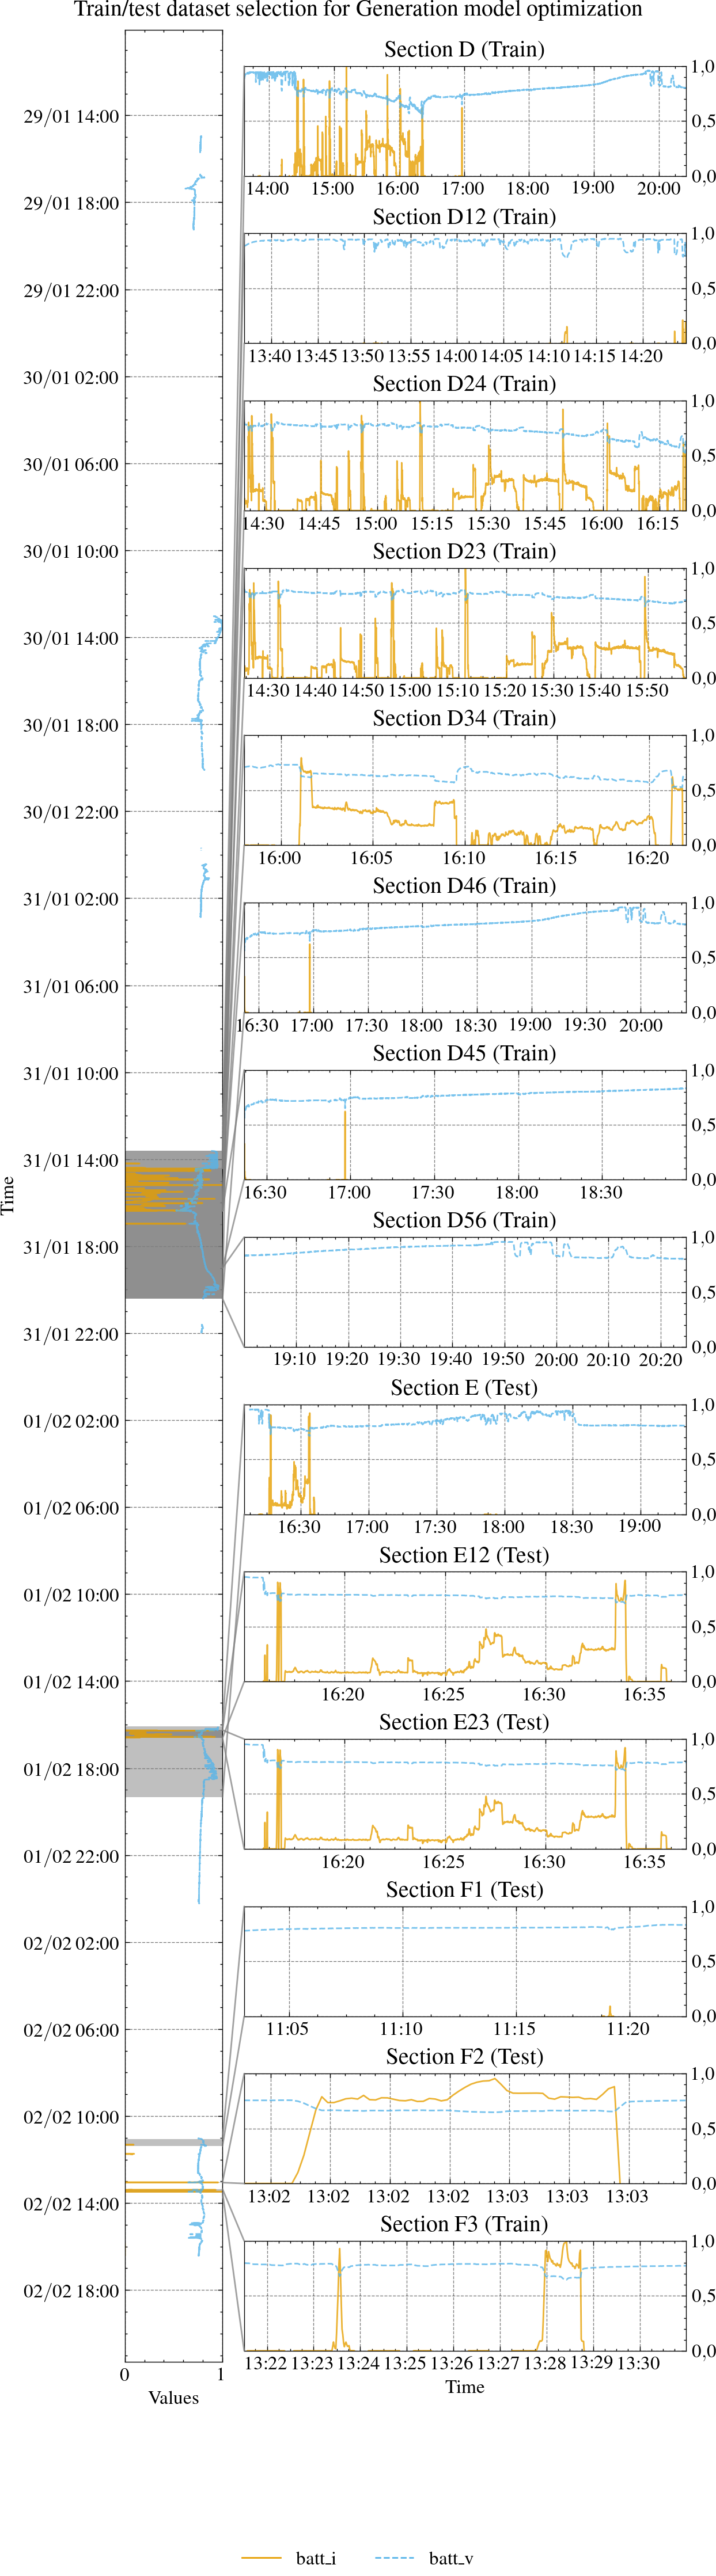

In [2]:
# filename = "../../../models/2020/boat_data_100ms.csv"
filename = "../../../models/2020/boat_data_1s.csv"
rename_columns = {
    'Battery Pack Voltage': 'batt_v',
    'Battery Current': 'batt_i',
    'ESC Duty Cycle': 'pilot_d',
    'Motor Angular Speed': 'motor_w',
    'ESC Input Current': 'esc_i_in',
    **{f'MPPT {i} Input Current': f'mppt{i}_i_in' for i in range(1,5)},
    **{f'MPPT {i} Input Voltage': f'mppt{i}_v_in' for i in range(1,5)},
    **{f'MPPT {i} Duty Cycle': f'mppt{i}_d' for i in range(1,5)},
    **{f'MPPT {i} Output Current': f'mppt{i}_i_out' for i in range(1,5)},
    # 'MPPTs Output Current': 'mppts_i_out',
    'PVs G': 'pv_g',
    # 'Solar POA': 'solar_poa',
    # 'Wind Speed': 'wind_v',
    # 'Air Temperature': 'air_t',
}
df = load_df(
    filename=filename,
    start=None,
    end=None,
    resample_rule=None,
    rename_columns=rename_columns,
    print_columns=False,
    iqr_threshold=None,
    cutoff_freq=None,
    sampling_rate=1,
    order=1,
)

sections, tzinfo = get_sections()

# Customizing ranges:
D1 = pd.Timestamp('2020-01-31 13:37:04')  # Pre-race charging starts, it starts with the battery almost (if not) fully charged, definitely overcharging it by the start of the race
D2 = pd.Timestamp('2020-01-31 14:24:40')  # start of the race
D3 = pd.Timestamp('2020-01-31 15:58:00')  # battery enters in deep-discharge
D4 = pd.Timestamp('2020-01-31 16:22:00')  # race finishes, post-race charge starts
D5 = pd.Timestamp('2020-01-31 19:00:00')  # overcharge starts
D6 = pd.Timestamp('2020-01-31 20:24:55')  # end of the day
sections.loc['Section D'] = [D1, D6]  # Full race event
sections.loc['Section D12'] = [D1, D2]  # Full pre-race charge
sections.loc['Section D24'] = [D2, D4]  # Full race discharge
sections.loc['Section D23'] = [D2, D3]  # Race normal discharge range
sections.loc['Section D34'] = [D3, D4]  # Race deep-discharge range
sections.loc['Section D46'] = [D4, D6]  # Full post-race charge
sections.loc['Section D45'] = [D4, D5]  # Post-race charge, only the normal charge part
sections.loc['Section D56'] = [D5, D6]  # Post-race charge, only the over-charge part
sections.loc['Section E'] = [pd.Timestamp('2020-02-01 16:05:00'), pd.Timestamp('2020-02-01 19:20:00')] # A quick 15min discharge followed by an overcharge
sections.loc['Section E12'] = [pd.Timestamp('2020-02-01 16:15:00'), pd.Timestamp('2020-02-01 16:37:00')] # A ~15min discharge
sections.loc['Section E23'] = [pd.Timestamp('2020-02-01 16:15:00'), pd.Timestamp('2020-02-01 16:37:00')] # Another over-charging section
sections.loc['Section F1'] = [pd.Timestamp('2020-02-02 11:03:00'), pd.Timestamp('2020-02-02 11:22:30')] # A quick charge section
sections.loc['Section F2'] = [pd.Timestamp('2020-02-02 13:02:15'), pd.Timestamp('2020-02-02 13:03:30')] # 2min high-current pulse
sections.loc['Section F3'] = [pd.Timestamp('2020-02-02 13:21:30'), pd.Timestamp('2020-02-02 13:31:00')] # wait, 10s high-current pulse, wait, then a 2min high-current pulse
sections = sections.loc[['Section D', 'Section D12', 'Section D24', 'Section D23', 'Section D34', 'Section D46', 'Section D45', 'Section D56', 'Section E', 'Section E12', 'Section E23', 'Section F1', 'Section F2', 'Section F3']]

train_sections_names = ['Section D', 'Section D12', 'Section D24', 'Section D23', 'Section D34', 'Section D46', 'Section D45', 'Section D56', 'Section F3']

train_test_sections = sections.reset_index().to_dict(orient='records')
train_sections = sections.loc[sections.index.intersection(train_sections_names)].reset_index().to_dict(orient='records')
test_sections = sections.loc[sections.index.difference(train_sections_names)].reset_index().to_dict(orient='records')
all_sections = sections.reset_index().to_dict(orient='records')

# Build union masks for train/test
train_mask = pd.Series(False, index=df.index)
test_mask  = pd.Series(False, index=df.index)

for sec in train_test_sections:
    mask = (df.index >= sec['start']) & (df.index <= sec['end'])
    if sec['name'] in train_sections_names:
        sec['name'] = sec['name'] + ' (Train)'
        train_mask |= mask
    else:
        sec['name'] = sec['name'] + ' (Test)'
        test_mask |= mask

# Ensure no sample is counted in both train and test
overlap = train_mask & test_mask
if overlap.any():
    raise ValueError("Some timestamps are in both train and test sections.")

train_size = df.loc[train_mask].size
test_size = df.loc[test_mask].size
total_size = train_size + test_size

print(f'Train size ≃ {100*train_size/total_size:.2f}%')
print(f'Test  size ≃ {100*test_size/total_size:.2f}%')

fig_save_and_show(
        filename=None,#f'{latex_img_path}/battery_optimization_test_residuals_{col}.pdf',
        show_title=f'Train/test dataset selection for Generation model optimization',
        save_title=f'Dataset da embarcação durante o DSB de 2019',
        ncol=4,
        fig=plot_events_data(
            events=train_test_sections,
            df=df,
            column_names=['batt_i', 'batt_v'],
            normalize=True,
        )
    )


# Solar Boat System model

In [ ]:
import numpy as np
import control as ct
import math

def eval_poly(coeffs, x):
    coeffs = list(coeffs)
    if len(coeffs) == 0:
        return 0.0
    if len(coeffs) == 1:
        return coeffs[0]

    result = 0.0
    for c in reversed(coeffs[1:]):
        result = result * x + c
    return result * x + coeffs[0]


class SolarBoat:
    @classmethod
    def initial_state(cls, X0: dict, U0, params: dict):
        """
        X0:
            batt_z : float, required
            batt_v : float, required (pack voltage)
            hull_u : float, optional (initial hull speed)

        U0:
            [pvs_g_0, pilot_d_0]
        """
        if 'batt_z' not in X0 or 'batt_v' not in X0:
            raise ValueError("X0 must contain 'batt_z' and 'batt_v' for SolarBoat.initial_state.")

        # Required initial conditions
        batt_z_0 = X0['batt_z']
        batt_v_0 = X0['batt_v']

        # Optional: initial hull speed
        hull_u_0 = X0.get('hull_u', 0.0)

        # Inputs
        # pvs_g_0 = U0[0] if len(U0) > 0 else 0.0
        pilot_d_0 = U0[1] if len(U0) > 1 else 0.0

        # --- Battery RC states ---------------------------------------------
        # Params
        batt_R_0 = params['batt_R_0']
        batt_k_V_OC_coeffs = params['batt_k_V_OC_coeffs']
        batt_N_S = params['batt_N_S']

        # [ASSUMPTION]: At t=0, battery current is 0 A when computing RC initial voltages.
        batt_i_0 = 0.0

        # OCV at initial SoC
        batt_ocv_0 = eval_poly(batt_k_V_OC_coeffs, batt_z_0)

        # v_C1_0 = v_C2_0 = v_C_0 so that terminal voltage matches batt_v_0:
        # batt_v_0 / batt_N_S = batt_ocv_0 - 2*v_C_0 - batt_R_0 * batt_i_0
        v_C_0 = (batt_ocv_0 - batt_R_0 * batt_i_0 - batt_v_0 / batt_N_S) / 2.0

        batt_v_C_1_0 = v_C_0
        batt_v_C_2_0 = v_C_0

        # --- Propulsion states ---------------------------------------------
        # [ASSUMPTION]: Motor starts from rest with zero current, and ESC duty equals pilot input.
        motor_i_0 = 0.0
        motor_w_0 = 0.0
        esc_d_0 = pilot_d_0

        return np.array([
            batt_z_0,        # batt_z
            batt_v_C_1_0,    # batt_v_C_1
            batt_v_C_2_0,    # batt_v_C_2
            motor_i_0,       # motor_i
            motor_w_0,       # motor_w
            esc_d_0,         # esc_d
            hull_u_0,        # hull_u
        ])

    @classmethod
    def _algebraic(cls, t, x, u, params: dict):
        """
        Compute all algebraic quantities (battery voltage, propeller forces, hull resistance, etc.)
        given the current state x and inputs u.
        """
        # Unpack params needed here

        # Battery params
        batt_N_S = params['batt_N_S']
        batt_k_V_OC_coeffs = params['batt_k_V_OC_coeffs']
        batt_R_0 = params['batt_R_0']

        # Battery dynamic params (for consistency in formulas)
        # batt_R_1 = params['batt_R_1']
        # batt_C_1 = params['batt_C_1']
        # batt_R_2 = params['batt_R_2']
        # batt_C_2 = params['batt_C_2']

        # Generation params
        pv_S = params['pv_S']
        pv_eta = params['pv_eta']
        mppt_eta = params['mppt_eta']
        mppts_n = params['mppts_n']

        # Propulsion / hull / prop params
        esc_eta = params['esc_eta']
        hull_C_T = params['hull_C_T']
        hull_S_air = params['hull_S_air']
        hull_S_water = params['hull_S_water']
        hull_W = params['hull_W']
        prop_D = params['prop_D']
        prop_k_Q_coeffs = params['prop_k_Q_coeffs']
        prop_k_T_coeffs = params['prop_k_T_coeffs']
        prop_eta_R      = params['prop_eta_R']
        rho_air = params['rho_air']
        rho_water = params['rho_water']
        trans_eta = params['trans_eta']
        trans_k = params['trans_k']
        others_pi = params['others_pi']

        # States
        batt_z = x[0]
        batt_v_C_1 = x[1]
        batt_v_C_2 = x[2]
        motor_i = x[3]
        motor_w = x[4]
        esc_d = x[5]
        hull_u = x[6]

        # Inputs
        pv_g = u[0]
        # pilot_d = u[1]  # not needed in algebraic part

        # Propeller kinematics
        prop_w = motor_w * trans_k
        prop_n = prop_w / (2 * np.pi)  # [RPS]

        eps = 1e-9
        u_rel = (1.0 - hull_W) * hull_u
        prop_J = np.clip(hull_u/(prop_D*(prop_n + eps)), a_min=0, a_max=1.5)  # avoid div by zero
        prop_J0 = np.clip(u_rel/(prop_D*(prop_n + eps)), a_min=0, a_max=1.5)  # avoid div by zero
        prop_k_q0 = max(0, eval_poly(prop_k_Q_coeffs, prop_J0))  # Assuming forward operation
        prop_k_t0 = max(0, eval_poly(prop_k_T_coeffs, prop_J0))  # Assuming forward operation

        prop_k_q = prop_k_q0 / prop_eta_R
        prop_k_t = prop_k_t0

        prop_q = prop_D**5 * prop_k_q * abs(prop_n) * prop_n * rho_water
        prop_t = prop_D**4 * prop_k_t * abs(prop_n) * prop_n * rho_water
        motor_q_load = prop_q * trans_k / trans_eta

        hull_r = hull_C_T * hull_u**2 * (hull_S_air * rho_air + hull_S_water * rho_water) / 2

        esc_i_in = esc_d*motor_i/esc_eta
        batt_ocv = eval_poly(batt_k_V_OC_coeffs, batt_z)
        batt_v = -batt_R_0*batt_N_S*esc_i_in/2 + math.sqrt(batt_N_S)*math.sqrt(4*batt_R_0*mppt_eta*mppts_n*pv_S*pv_eta*pv_g - 4*batt_R_0*others_pi + batt_N_S*(batt_R_0*esc_i_in - batt_ocv + batt_v_C_1 + batt_v_C_1)**2)/2 + batt_N_S*batt_ocv/2 - batt_N_S*(batt_v_C_1 + batt_v_C_2)/2
        motor_v = batt_v*esc_d
        mppts_i_out = mppt_eta*mppts_n*pv_S*pv_eta*pv_g/batt_v
        others_ii = others_pi/batt_v
        batt_i = esc_i_in - mppts_i_out + others_ii

        return {
            'batt_v': batt_v,
            'batt_z': batt_z,
            'batt_ocv': batt_ocv,
            'batt_i': batt_i,
            'mppts_i_out': mppts_i_out,
            'motor_v': motor_v,
            'motor_i': motor_i,
            'motor_w': motor_w,
            'motor_q_load': motor_q_load,
            'esc_d': esc_d,
            'esc_i_in': esc_i_in,
            'prop_w': prop_w,
            'prop_J': prop_J,
            'prop_k_q': prop_k_q,
            'prop_k_t': prop_k_t,
            'prop_q': prop_q,
            'prop_t': prop_t,
            'hull_u': hull_u,
            'hull_r': hull_r,
        }

    @classmethod
    def _update(cls, t, x, u, params: dict):
        # Params needed for dynamics

        # Battery dynamic params
        batt_eta = params['batt_eta']
        batt_Q = params['batt_Q']
        batt_R_1 = params['batt_R_1']
        batt_C_1 = params['batt_C_1']
        batt_R_2 = params['batt_R_2']
        batt_C_2 = params['batt_C_2']

        # Motor / propulsion dynamic params
        esc_tau_fall = params['esc_tau_fall']
        esc_tau_rise = params['esc_tau_rise']
        hull_M = params['hull_M']
        hull_T_ded = params['hull_T_ded']
        motor_B = params['motor_B']
        motor_I_r = params['motor_I_r']
        motor_K_Q = params['motor_K_Q']
        motor_L_A = params['motor_L_A']
        motor_R_A = params['motor_R_A']
        prop_I_r = params['prop_I_r']
        trans_Iri = params['trans_Iri']
        trans_Iro = params['trans_Iro']
        trans_k = params['trans_k']

        motor_I_r_load = trans_Iri + trans_k**2 * (trans_Iro + prop_I_r)

        # States
        # batt_z = x[0]
        batt_v_C_1 = x[1]
        batt_v_C_2 = x[2]
        motor_i = x[3]
        motor_w = x[4]
        esc_d = x[5]
        # hull_u = x[6]

        # Inputs
        # u = (pv_g, pilot_d)
        pilot_d = u[1]

        # Algebraic quantities
        alg = cls._algebraic(t, x, u, params)
        batt_i = alg['batt_i']
        motor_v = alg['motor_v']
        motor_q_load = alg['motor_q_load']
        prop_t = alg['prop_t']
        hull_r = alg['hull_r']

        # Battery dynamics
        d_batt_z = -batt_eta * batt_i / batt_Q
        d_batt_v_C_1 = -(batt_v_C_1 / (batt_R_1 * batt_C_1)) + (batt_i / batt_C_1)
        d_batt_v_C_2 = -(batt_v_C_2 / (batt_R_2 * batt_C_2)) + (batt_i / batt_C_2)

        # Motor current dynamics
        d_motor_i = (-motor_R_A * motor_i - motor_K_Q * motor_w + motor_v) / motor_L_A

        # Motor speed dynamics
        d_motor_w = (-motor_B * motor_w + motor_i * motor_K_Q - motor_q_load) / (motor_I_r + motor_I_r_load)

        # ESC duty-cycle dynamics
        if pilot_d > esc_d:
            d_esc_d = (pilot_d - esc_d) / esc_tau_rise
        else:
            d_esc_d = (pilot_d - esc_d) / esc_tau_fall

        # Hull speed dynamics
        prop_t_eff = (1.0 - hull_T_ded) * prop_t
        d_hull_u = (prop_t_eff - hull_r) / hull_M

        return np.array([
            d_batt_z,
            d_batt_v_C_1,
            d_batt_v_C_2,
            d_motor_i,
            d_motor_w,
            d_esc_d,
            d_hull_u,
        ])

    @classmethod
    def _outputs(cls, t, x, u, params: dict):
        alg = cls._algebraic(t, x, u, params)

        batt_v = alg['batt_v']
        batt_z = alg['batt_z']
        batt_ocv = alg['batt_ocv']
        batt_i = alg['batt_i']
        mppts_i_out= alg['mppts_i_out']
        motor_v = alg['motor_v']
        motor_w = alg['motor_w']
        motor_i = alg['motor_i']
        motor_q_load = alg['motor_q_load']
        esc_d = alg['esc_d']
        esc_i_in = alg['esc_i_in']
        prop_w = alg['prop_w']
        prop_q = alg['prop_q']
        prop_t = alg['prop_t']
        hull_u = alg['hull_u']
        hull_r = alg['hull_r']

        return np.array([
            batt_v,      # 0
            batt_z,      # 1
            batt_ocv,    # 2
            batt_i,      # 3
            mppts_i_out,    # 4
            motor_v,     # 5
            motor_w,     # 6
            motor_i,     # 7
            motor_q_load,# 8
            esc_d,       # 9
            esc_i_in,      # 10
            prop_w,      # 11
            prop_q,      # 12
            prop_t,      # 13
            hull_u,      # 14
            hull_r,      # 15
        ])

    @classmethod
    def build(cls, params: dict):
        return ct.NonlinearIOSystem(
            cls._update,
            cls._outputs,
            name='solarboat',
            states=('batt_z', 'batt_v_C_1', 'batt_v_C_2', 'motor_i', 'motor_w', 'esc_d', 'hull_u'),
            inputs=('pv_g', 'pilot_d'),
            outputs=(
                'batt_v',
                'batt_z',
                'batt_ocv',
                'batt_i',
                'mppts_i_out',
                'motor_v',
                'motor_w',
                'motor_i',
                'motor_q_load',
                'esc_d',
                'esc_i_in',
                'prop_w',
                'prop_q',
                'prop_t',
                'hull_u',
                'hull_r',
            ),
            params=params,
        )

SolarBoat.build({})

<NonlinearIOSystem solarboat: ['pv_g', 'pilot_d'] -> ['batt_v', 'batt_z', 'batt_ocv', 'batt_i', 'mppts_io', 'motor_v', 'motor_w', 'motor_i', 'motor_q_load', 'esc_d', 'esc_i_in', 'prop_w', 'prop_q', 'prop_t', 'hull_u', 'hull_r']>

In [4]:
propulsion_params = {
    # From models/2020/Motor/me0909_free_rotor_step.ipynb
    # From models/2020/propulsion/propulsion_single_block_simplified_revised_pymoo.ipynb
    'motor_R_A': 0.01953449524955559,
    'motor_B': 0.0012072185526191795,
    'motor_K_Q': 0.10484792245639701,
    'motor_L_A': 6.329544121644985e-05,
    'motor_I_r': 0.011943907654470355,
    'rho_water': 1023,
    'rho_air': 1.1839,
    'esc_eta': 0.866,
    'esc_tau_fall': 1.2750449985439274,
    'esc_tau_rise': 0.25534685827849624,
    'trans_eta': 0.9,
    'trans_Iri': 0,
    'trans_Iro': 0,
    'trans_k': 0.6363636363636364,
    'prop_D': 0.2286,
    'prop_k_T_coeffs': [0.09999871540716215, 0.06596122303461704],
    'prop_k_Q_coeffs': [0.011187180876140401, 0.06590461151481068],
    'prop_eta_R': 1,
    'prop_I_r': 0.0709943727701415,
    'hull_C_T': 0.005475489082603877,
    'hull_M': 293.7,
    'hull_S_water': 4.142904990019334,
    'hull_S_air': 4.094995009980666,
    'hull_T_ded': 0.0855,
    'hull_W': 0.1425,
}

propulsion_params = propulsion_params | {'hull_C_T': 0.007909046973447596,
 'prop_I_r': 0.009413168259632173,
 'hull_W': 0.0021586352179196223,
 'hull_T_ded': 0.0009965647618903938,
 'esc_tau_rise': 0.4314466540810037,
 'esc_tau_fall': 0.6253058776723913,
 'prop_k_Q_coeffs': [0.03786242059403999,
  -0.01057659124381085,
  0.00036827477946659547,
  -0.006494220858274719],
 'prop_k_T_coeffs': [0.23127664898249156,
  -0.09149342570939362,
  -0.10047346323082776,
  0.039296712884900456]}

generation_params = {
    # From models/2020/generation/generation_step.ipynb
    'pv_S': 1.650 * 0.992,
    'pv_eta': 0.15553439343946882,
    'mppt_eta': 0.9169846082963471,
    'mppts_n': 4,
}

battery_params = {
    # From models/2020/battery/PNGV_1rc_model_continuous_curve_fitting_pymoo.ipynb
    'batt_N_S': 3,
    'batt_Q': 48 * 3600,
    'batt_eta': 1,
    'batt_R_0': 0.0046351552806151025,
    'batt_R_1': 0.005567185408885957,
    'batt_C_1': 374.0952049310755,
    'batt_R_2': 0.022681056911324566,
    'batt_C_2': 107967.56094014487,
    'batt_k_V_OC_coeffs': np.array([10.78645833,  3.58638935, -3.07530114,  1.61637218]),
 }

others_params = {
    'others_pi': 1.5 * 18,
}

solar_boat_params = generation_params | battery_params | propulsion_params | others_params
solar_boat_params

{'pv_S': 1.6367999999999998,
 'pv_eta': 0.15553439343946882,
 'mppt_eta': 0.9169846082963471,
 'mppts_n': 4,
 'batt_N_S': 3,
 'batt_Q': 172800,
 'batt_eta': 1,
 'batt_R_0': 0.0046351552806151025,
 'batt_R_1': 0.005567185408885957,
 'batt_C_1': 374.0952049310755,
 'batt_R_2': 0.022681056911324566,
 'batt_C_2': 107967.56094014487,
 'batt_k_V_OC_coeffs': array([10.78645833,  3.58638935, -3.07530114,  1.61637218]),
 'motor_R_A': 0.01953449524955559,
 'motor_B': 0.0012072185526191795,
 'motor_K_Q': 0.10484792245639701,
 'motor_L_A': 6.329544121644985e-05,
 'motor_I_r': 0.011943907654470355,
 'rho_water': 1023,
 'rho_air': 1.1839,
 'esc_eta': 0.866,
 'esc_tau_fall': 0.6253058776723913,
 'esc_tau_rise': 0.4314466540810037,
 'trans_eta': 0.9,
 'trans_Iri': 0,
 'trans_Iro': 0,
 'trans_k': 0.6363636363636364,
 'prop_D': 0.2286,
 'prop_k_T_coeffs': [0.23127664898249156,
  -0.09149342570939362,
  -0.10047346323082776,
  0.039296712884900456],
 'prop_k_Q_coeffs': [0.03786242059403999,
  -0.01057659

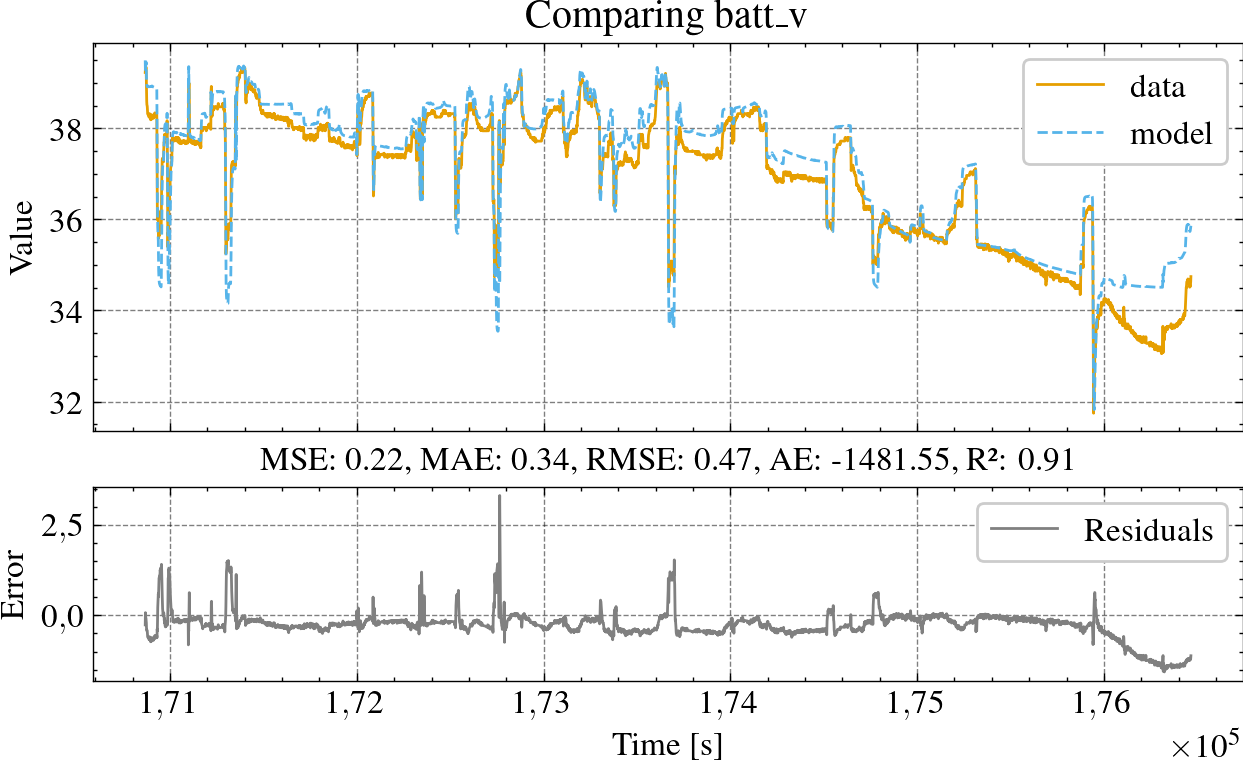

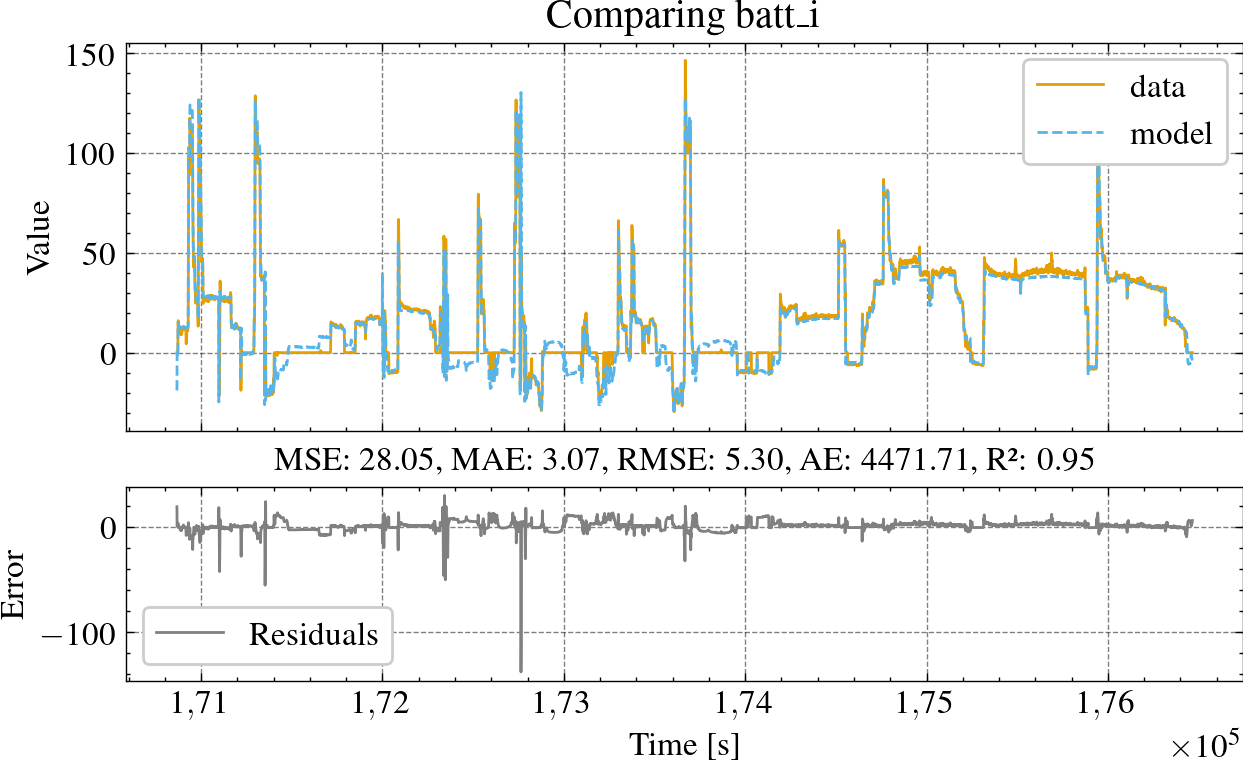

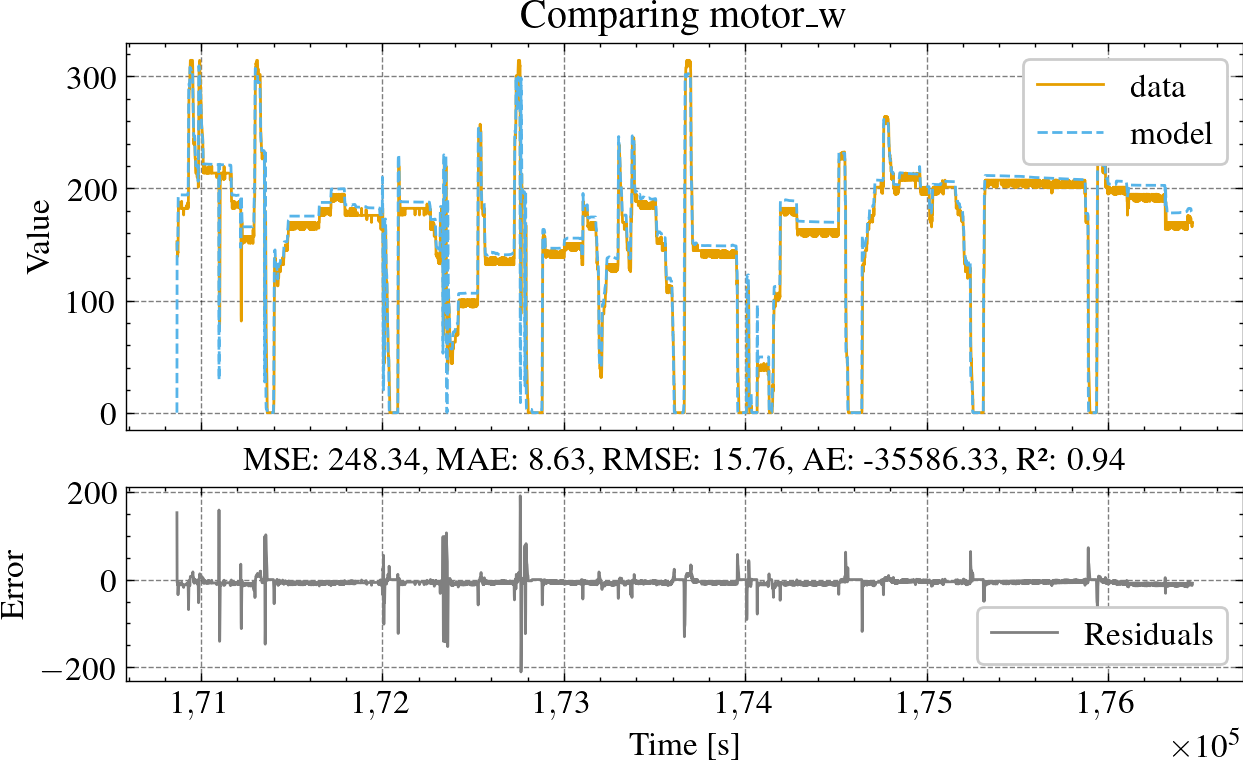

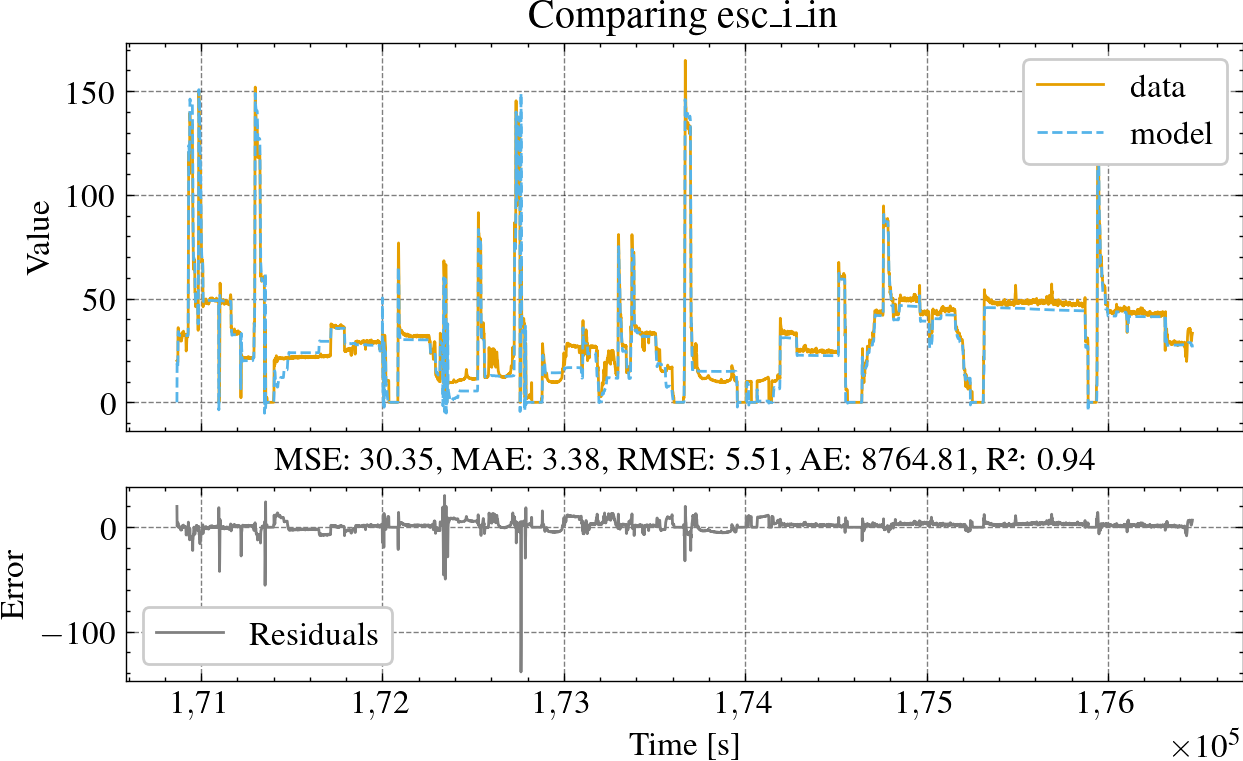

In [5]:
model = SolarBoat
model_params = solar_boat_params.copy()

# Model
solar_boat = model.build(model_params)

data_cols = [c for c in list(df.columns) if c in solar_boat.output_labels]
input_cols = solar_boat.input_labels
section_name = 'Section D23'
section = next(s for s in all_sections if s['name'] == section_name)
df_section = df.loc[(df.index >= section['start']) & (df.index <= section['end']), ['t'] + data_cols + input_cols]

# Time array
T = np.ascontiguousarray(df_section['t'].to_numpy())

# Inputs
U = np.ascontiguousarray(df_section[input_cols].to_numpy().T)

# Initial state
X0 = model.initial_state(
    X0={
        'batt_z': 1.1,
        'batt_v': float(df_section['batt_v'].iloc[0])
    },
    U0=U[:, 0],
    params=model_params,
)

# Simulation
res = ct.input_output_response(solar_boat, T=T, U=U, X0=X0, solve_ivp_method='Radau')
df_pred = res.to_pandas().set_index('time')

for column in data_cols:
    plot_compare(df_section, df_pred, column)

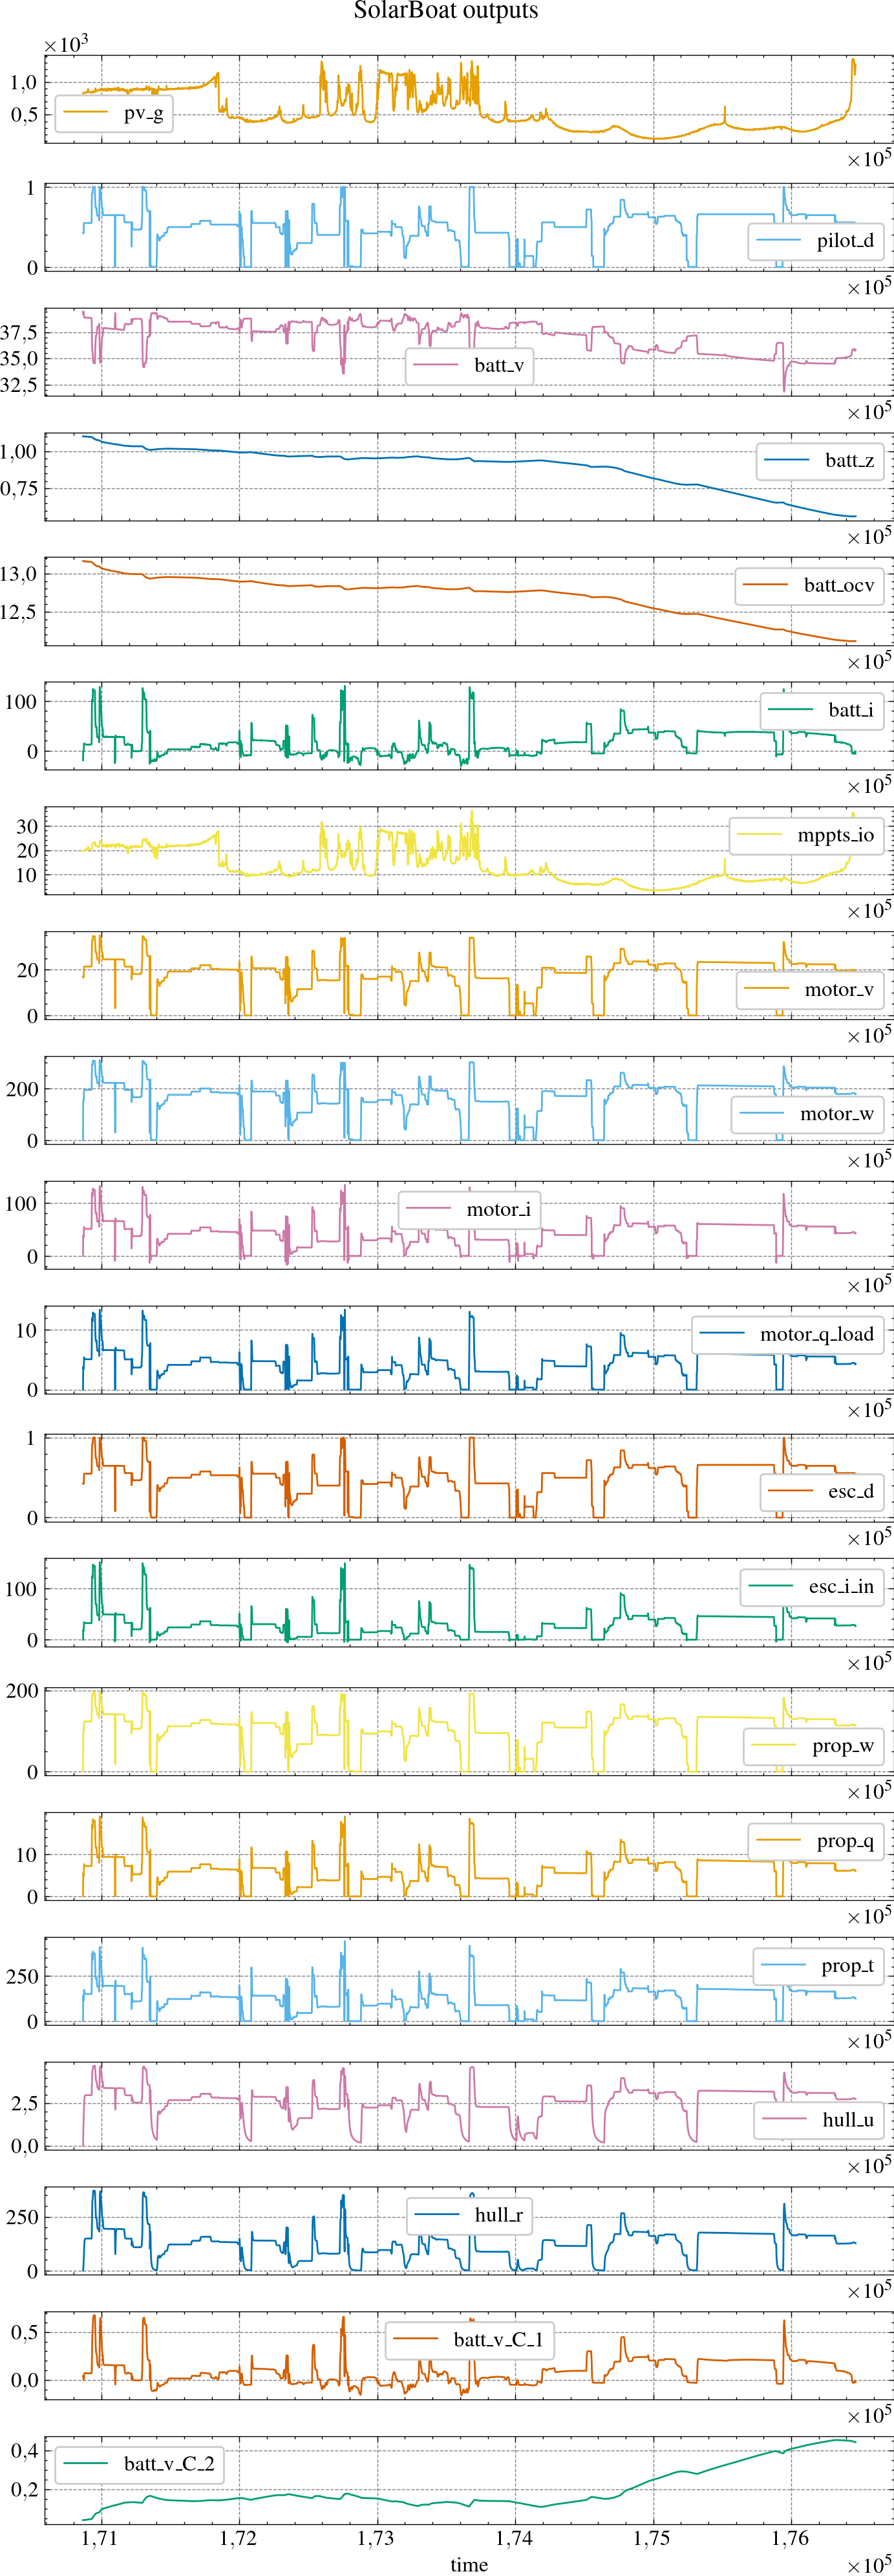

In [6]:
df_pred.plot(subplots=True, figsize=(7,20), title="SolarBoat outputs")
plt.show()

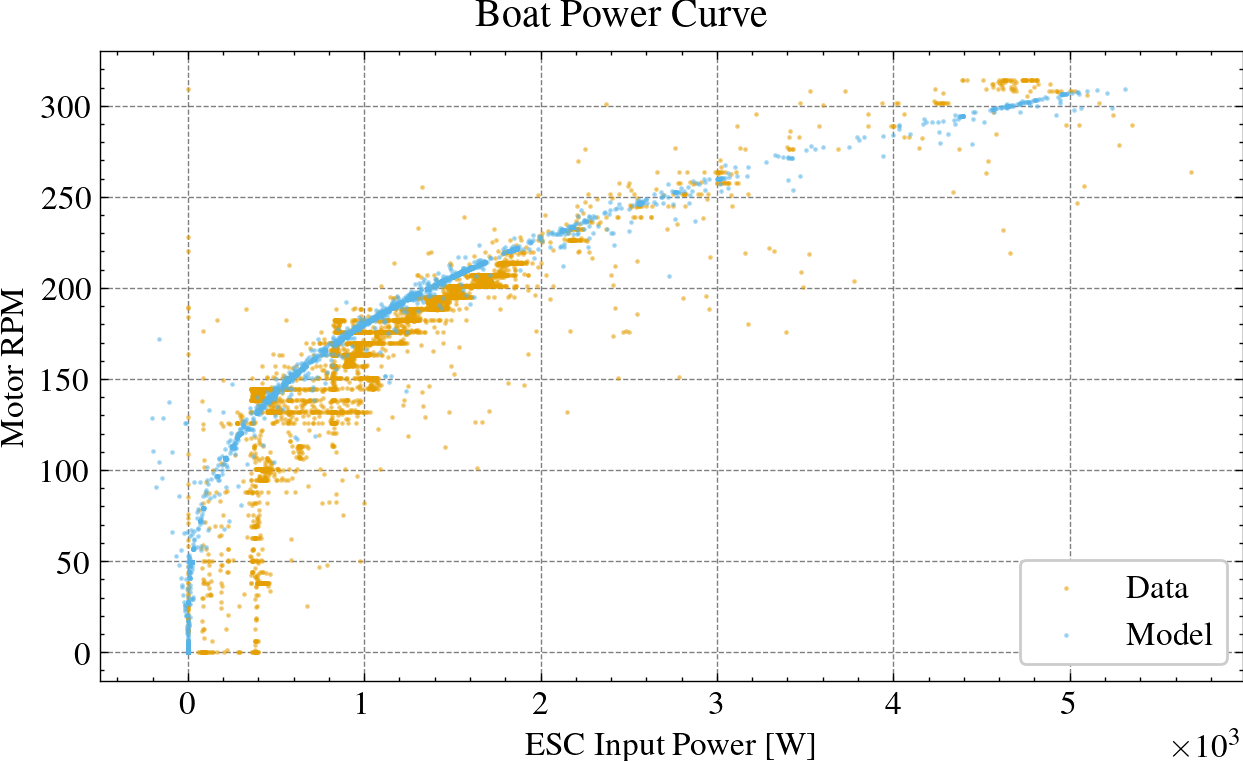

In [7]:
plt.figure()
plt.scatter(df_section['batt_v'].to_numpy()*df_section['esc_i_in'].to_numpy(), df_section['motor_w'], s=0.5, alpha=0.5, label='Data')
plt.scatter(df_pred['batt_v'].to_numpy()*df_pred['esc_i_in'].to_numpy(), df_pred['motor_w'], s=0.5, alpha=0.5, label='Model')
plt.suptitle('Boat Power Curve')
plt.ylabel('Motor RPM')
plt.xlabel('ESC Input Power [W]')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def add_derived_columns(df_pred, propulsion_params, generation_params, battery_params, others_params):
    df = df_pred.copy()

    rho_water = propulsion_params["rho_water"]
    prop_D = propulsion_params["prop_D"]

    # 1) Propeller dimensionless coefficients and open-water efficiency
    # ---------------------------------------------------------------
    # prop_n: shaft revolutions per second
    df["prop_n"] = df["prop_w"] / (2.0 * np.pi)

    mask_n = df["prop_n"].abs() > 1e-6

    df["J"] = np.nan
    df.loc[mask_n, "J"] = df.loc[mask_n, "hull_u"] / (df.loc[mask_n, "prop_n"] * prop_D)

    df["K_T"] = np.nan
    df["K_Q"] = np.nan
    df.loc[mask_n, "K_T"] = (
        df.loc[mask_n, "prop_t"]
        / (rho_water * df.loc[mask_n, "prop_n"] ** 2 * prop_D ** 4)
    )
    df.loc[mask_n, "K_Q"] = (
        df.loc[mask_n, "prop_q"]
        / (rho_water * df.loc[mask_n, "prop_n"] ** 2 * prop_D ** 5)
    )

    df["eta0"] = np.nan
    mask_eff = mask_n & (df["K_Q"].abs() > 1e-9)
    df.loc[mask_eff, "eta0"] = (
        df.loc[mask_eff, "J"] * df.loc[mask_eff, "K_T"]
        / (2.0 * np.pi * df.loc[mask_eff, "K_Q"])
    )

    # 2) Power flow along the chain
    # -----------------------------
    # PV → MPPT → DC bus
    K_pv = (
        generation_params["pv_S"]
        * generation_params["pv_eta"]
        * generation_params["mppt_eta"]
        * generation_params["mppts_n"]
    )
    df["P_pv"] = K_pv * df["pv_g"]                      # theoretical PV→bus power [W]
    df["P_mppt_out"] = df["batt_v"] * df["mppts_i_out"]     # MPPT current * bus voltage

    # Battery power (positive = discharge)
    df["P_batt"] = df["batt_v"] * df["batt_i"]

    # DC bus power into ESC (ESC input current times bus voltage)
    df["P_esc_in"] = df["batt_v"] * df["esc_i_in"]

    # Motor electrical power
    df["P_motor_elec"] = df["motor_v"] * df["motor_i"]

    # Motor shaft power (electromagnetic torque * speed)
    df["P_shaft"] = df["motor_q_load"] * df["motor_w"]

    # Propeller power (hydrodynamic torque * speed)
    df["P_prop"] = df["prop_q"] * df["prop_w"]

    # Useful hydrodynamic power (towing power)
    df["P_hull"] = df["hull_u"] * df["hull_r"]

    # Other constant onboard loads
    df["P_others"] = others_params["others_pi"]

    # 3) Efficiencies along the chain
    # -------------------------------
    eps = 1e-9

    # PV+MPPT efficiency (as seen on DC bus)
    df["eta_pv_mppt"] = df["P_mppt_out"] / (df["P_pv"] + eps)

    # ESC efficiency (bus → motor terminals)
    df["eta_esc"] = df["P_motor_elec"] / (df["P_esc_in"] + eps)

    # Motor efficiency (electrical → shaft)
    df["eta_motor"] = df["P_shaft"] / (df["P_motor_elec"] + eps)

    # Transmission efficiency (shaft → prop torque)
    df["eta_trans"] = df["P_prop"] / (df["P_shaft"] + eps)

    # Propulsive efficiency (prop → hull)
    df["eta_propulsive"] = df["P_hull"] / (df["P_prop"] + eps)

    # Overall “from PV+Battery to hull” efficiency
    df["P_input_total"] = df["P_pv"] + df["P_batt"]
    df["eta_overall"] = df["P_hull"] / (df["P_input_total"] + eps)

    return df


df_new = add_derived_columns(df_pred, propulsion_params, generation_params, battery_params, others_params)


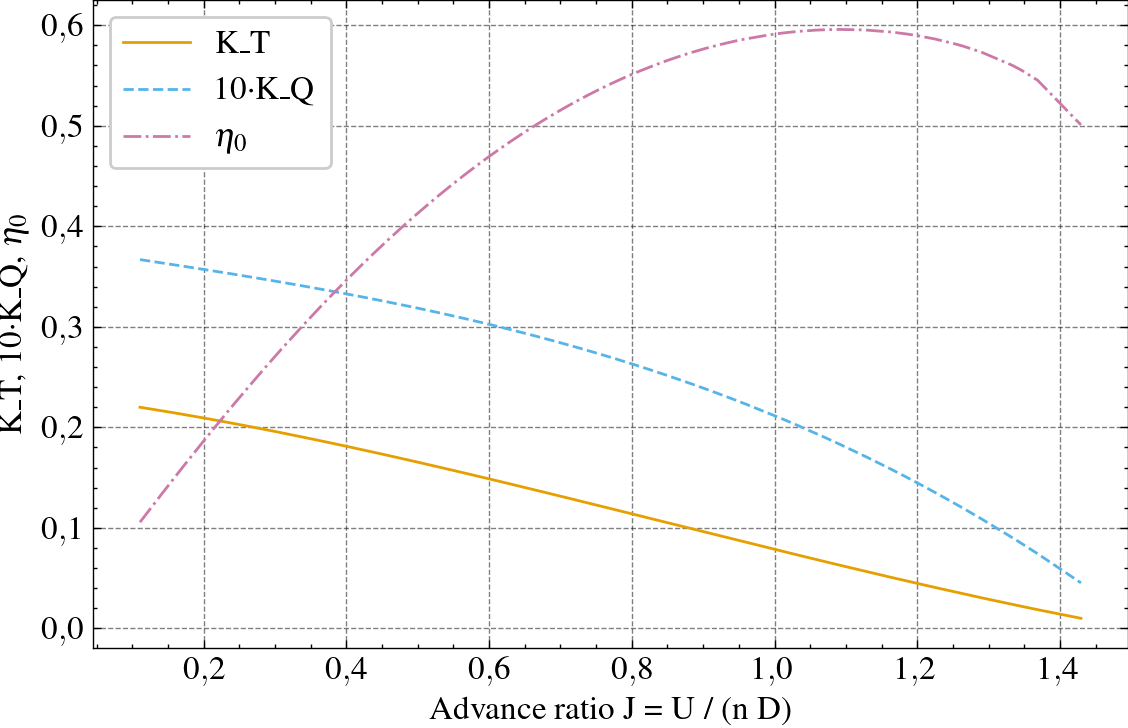

In [9]:
# 1. Classical propeller performance curve (K_T, 10K_Q, $\eta_0$ vs J)

prop_D     = propulsion_params["prop_D"]
rho_water  = propulsion_params["rho_water"]
hull_W  = propulsion_params["hull_W"]

def filter_prop_p_outints(df):
    df = df.copy()

    # Kinematics
    df["prop_n"] = df["prop_w"] / (2*np.pi)                       # [rev/s]
    df["u_rel"]  = (1.0 - hull_W) * df["hull_u"]               # inflow at prop
    df["J"]      = df["u_rel"] / (df["prop_n"] * prop_D)

    # Basic operating filters
    m = (
        (df["prop_n"].abs() > 1)      # ~>12 rpm
        & (df["u_rel"] > 0.1)           # avoid U≈0
        & (df["prop_t"] > 1.0)          # avoid almost-zero thrust
        & (df["prop_q"] > 0.05)         # positive, non-trivial torque
        & (df["J"] > 0)
        & np.isfinite(df["J"])
    )
    df = df[m].copy()

    # Dimensionless coefficients
    df["K_T"] = df["prop_t"] / (rho_water * df["prop_n"]**2 * prop_D**4)
    df["K_Q"] = df["prop_q"] / (rho_water * df["prop_n"]**2 * prop_D**5)

    # Physical ranges for KT, KQ (tune as you like)
    m_phys = (
        (df["K_T"] > 0.0) & (df["K_T"] < 0.4) &
        (df["K_Q"] > 0.0) & (df["K_Q"] < 0.1)
    )
    df = df[m_phys].copy()

    # Efficiency
    df["eta0"] = df["J"] * df["K_T"] / (2*np.pi * df["K_Q"])

    # Filter absurd efficiencies and J outliers
    m_eta = (
        (df["eta0"] > 0.0) & (df["eta0"] < 1) &
        (df["J"] < 1.5)
    )
    df = df[m_eta].copy()
    return df


df_prop = filter_prop_p_outints(df_new).sort_values("J")

fig, ax1 = plt.subplots(figsize=(6, 4))

ax1.plot(df_prop["J"], df_prop["K_T"], label="K_T")
ax1.plot(df_prop["J"], 10.0 * df_prop["K_Q"], label="10·K_Q")
ax1.plot(df_prop["J"], df_prop["eta0"], label=r'$\eta_0$')
ax1.set_xlabel("Advance ratio J = U / (n D)")
ax1.set_ylabel(r'K_T, 10·K_Q, $\eta_0$')
ax1.grid(True)

ax1.legend(loc="best")
plt.tight_layout()
plt.show()


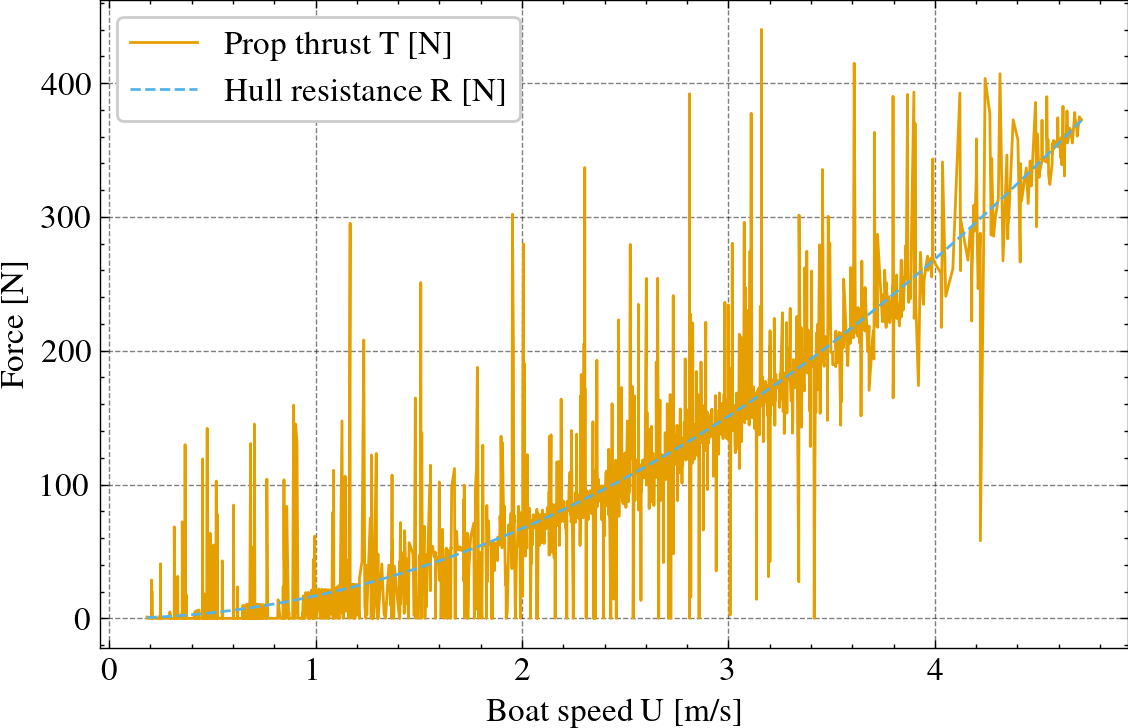

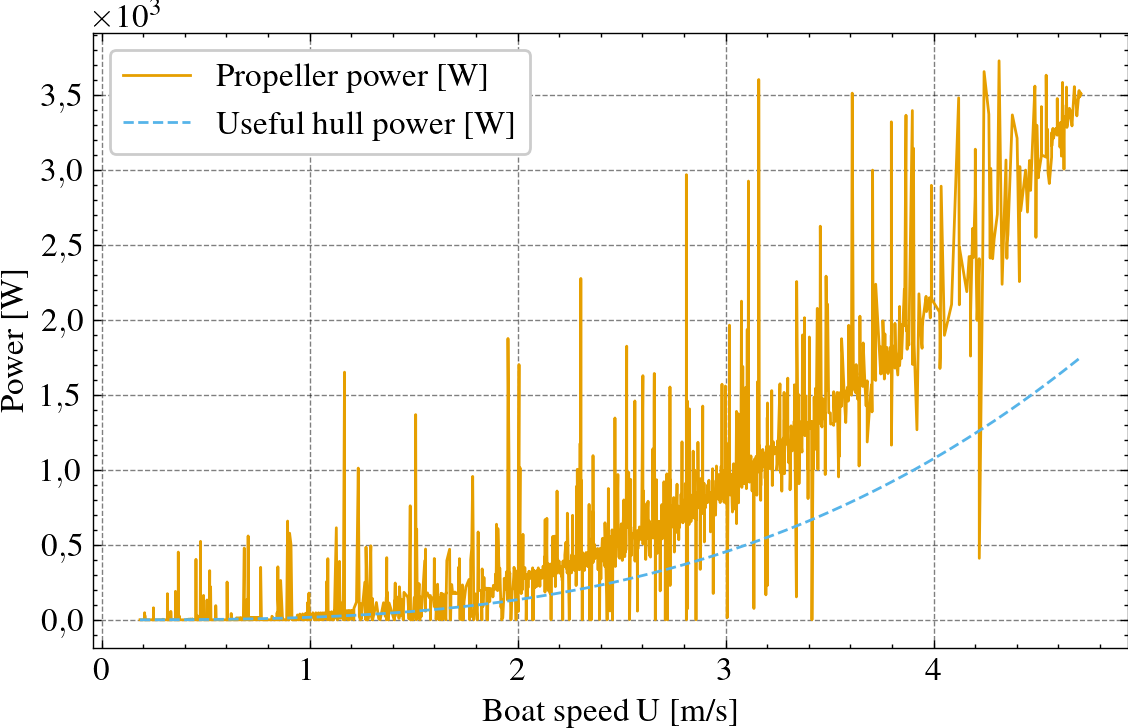

In [10]:
# 2. Boat performance curve (thrust vs resistance vs speed)

mask = df_new["hull_u"] > 0.0
df_boat = df_new[mask].copy().sort_values("hull_u")

plt.figure(figsize=(6, 4))
plt.plot(df_boat["hull_u"], df_boat["prop_t"], label="Prop thrust T [N]")
plt.plot(df_boat["hull_u"], df_boat["hull_r"], label="Hull resistance R [N]")
plt.xlabel("Boat speed U [m/s]")
plt.ylabel("Force [N]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(df_boat["hull_u"], df_boat["P_prop"], label="Propeller power [W]")
plt.plot(df_boat["hull_u"], df_boat["P_hull"], label="Useful hull power [W]")
plt.xlabel("Boat speed U [m/s]")
plt.ylabel("Power [W]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



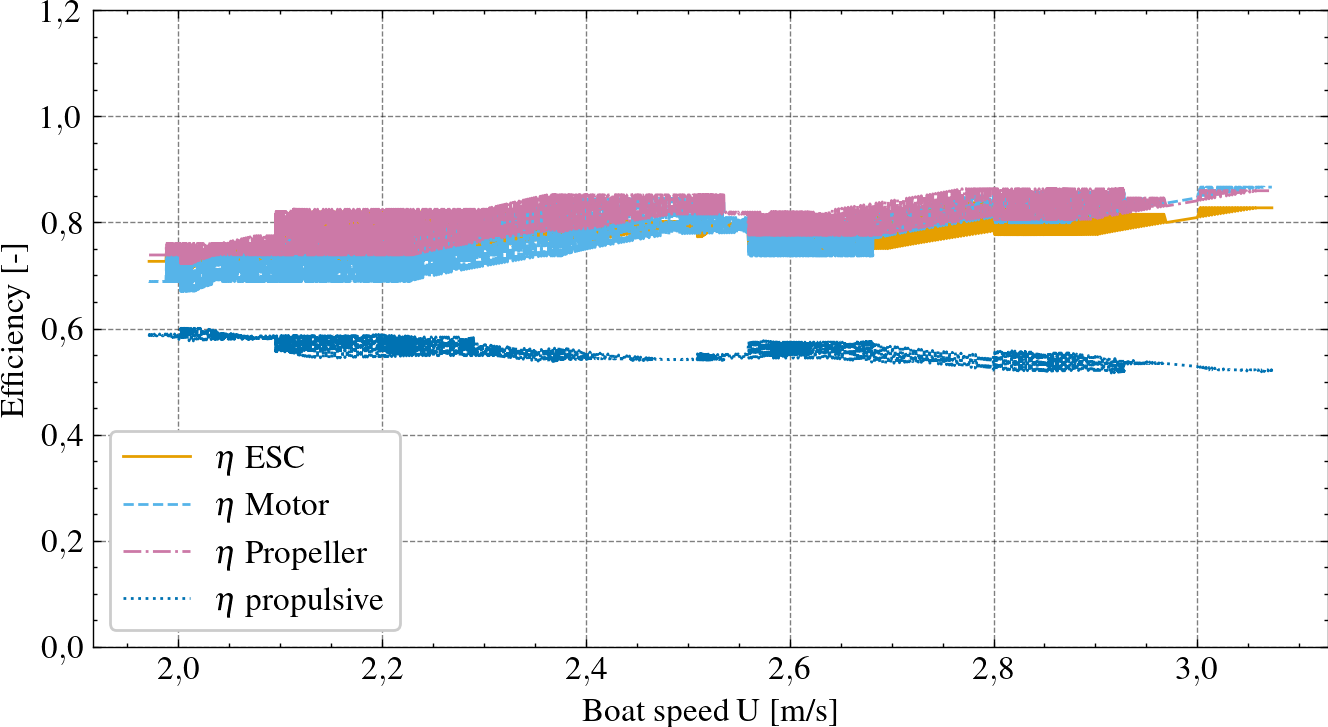

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def add_derived_columns(df_pred, params):
    df = df_pred.copy()

    rho_water = params["rho_water"]
    prop_D = params["prop_D"]

    # 1) Propeller dimensionless coefficients and open-water efficiency
    # ---------------------------------------------------------------
    # prop_n: shaft revolutions per second
    df["prop_n"] = df["prop_w"] / (2.0 * np.pi)

    mask_n = df["prop_n"].abs() > 1e-6

    df["J"] = np.nan
    df.loc[mask_n, "J"] = df.loc[mask_n, "hull_u"] / (df.loc[mask_n, "prop_n"] * prop_D)

    df["K_T"] = np.nan
    df["K_Q"] = np.nan
    df.loc[mask_n, "K_T"] = (
        df.loc[mask_n, "prop_t"]
        / (rho_water * df.loc[mask_n, "prop_n"] ** 2 * prop_D ** 4)
    )
    df.loc[mask_n, "K_Q"] = (
        df.loc[mask_n, "prop_q"]
        / (rho_water * df.loc[mask_n, "prop_n"] ** 2 * prop_D ** 5)
    )

    df["eta0"] = np.nan
    mask_eff = mask_n & (df["K_Q"].abs() > 1e-9)
    df.loc[mask_eff, "eta0"] = (
        df.loc[mask_eff, "J"] * df.loc[mask_eff, "K_T"]
        / (2.0 * np.pi * df.loc[mask_eff, "K_Q"])
    )

    # 2) Power flow along the chain
    # -----------------------------
    # PV → MPPT → DC bus
    mppts_n = params["mppts_n"]
    pv_S = params["pv_S"]
    pv_eta = params["pv_eta"]
    df['pvs_pi'] = mppts_n * pv_S * df["pv_g"]
    df["mppts_pi"] = mppts_n * pv_eta * df["pv_g"]   # theoretical PV→bus power [W]
    df["mppts_po"] = df["batt_v"] * df["mppts_i_out"]    # MPPT current * bus voltage

    # Battery power (positive = discharge), batt_i accounts for the whole system, ranges from negative (charging) to positive (discharging)
    df["batt_p"] = df["batt_v"] * df["batt_i"]

    # DC bus power into ESC (ESC input current times bus voltage)
    df["esc_p_in"] = df["batt_v"] * df["esc_i_in"]

    # Motor electrical power
    df["motor_p_in"] = df["motor_v"] * df["motor_i"]

    # Motor shaft power (electromagnetic torque * speed)
    df["motor_p_out"] = df["motor_q_load"] * df["motor_w"]

    # Propeller power (hydrodynamic torque * speed)
    df["prop_p"] = df["prop_q"] * df["prop_w"]

    # Useful hydrodynamic power (towing power)
    df["hull_p"] = df["hull_u"] * df["hull_r"]

    # Other constant onboard loads
    df["others_pi"] = others_params["others_pi"]

    # 3) Efficiencies along the chain
    # -------------------------------
    eps = 1e-3

    # PV+MPPT efficiency (as seen on DC bus)
    df["eta_pvs"] = np.minimum(1, df["mppts_pi"] / (df["pvs_pi"] + eps))
    df["eta_mppts"] = np.minimum(1, df["mppts_po"] / (df["mppts_pi"] + eps))

    # ESC efficiency (bus → motor terminals)
    df["eta_esc"] = np.minimum(1, df["motor_p_in"] / (df["esc_p_in"] + eps))

    # Motor efficiency (electrical → shaft)
    df["eta_motor"] = np.minimum(1, df["motor_p_out"] / (df["motor_p_in"] + eps))

    # Transmission efficiency (shaft → prop torque)
    df["eta_prop"] = np.minimum(1, df["prop_p"] / (df["motor_p_out"] + eps))

    # Propulsive efficiency (prop → hull)
    df["eta_propulsive"] = np.minimum(1, df["hull_p"] / (df["prop_p"] + eps))

    return df


df_new = add_derived_columns(df_pred, solar_boat_params)


# 3. System efficiencies along the chain

df_eff = df_new.copy().rolling(window=1000, center=True).mean().sort_values("hull_u")

plt.figure(figsize=(7, 4))
# plt.plot(df_eff["hull_u"], df_eff["eta_pvs"], label=r'$\eta$ PVs')
# plt.plot(df_eff["hull_u"], df_eff["eta_mppts"], label=r'$\eta$ MPPTs')
plt.plot(df_eff["hull_u"], df_eff["eta_esc"], label=r'$\eta$ ESC')
plt.plot(df_eff["hull_u"], df_eff["eta_motor"], label=r'$\eta$ Motor')
plt.plot(df_eff["hull_u"], df_eff["eta_prop"], label=r'$\eta$ Propeller')
plt.plot(df_eff["hull_u"], df_eff["eta_propulsive"], label=r'$\eta$ propulsive')

plt.xlabel("Boat speed U [m/s]")
plt.ylabel("Efficiency [-]")
plt.ylim(0, 1.2)  # adjust as needed
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
